In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext autotime

import warnings
warnings.filterwarnings('ignore')

from ngram import *
from baselines import *
from error_analysis import *

### Load Annotated Data

In [2]:
task = 'recipient'
xtype = 'comments'
ytype = 'plurality'
n_classes = 2
annotations = load_annotations()

time: 26.9 s


In [3]:
data = label_and_split(annotations, task)
X_train, y_train = assemble_data(data, xtype, ytype, splits = ['train'])
X_test, y_test = assemble_data(data, xtype, 'empirical_dist', splits = ['test'])

time: 2min 31s


### Hyper-Parameter tuning

In [4]:
cv_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', LogisticRegression(solver = 'sag')),
])

time: 2.52 ms


In [5]:
param_grid = {
    'vect__max_features': (500, 5000, 10000, 50000, None), 
    'vect__ngram_range': ((1,5),),  
    'vect__analyzer' : ('char',), 
}

tune (X_train, y_train, cv_pipeline, param_grid, roc_scorer, n_jobs=8, verbose=True)


Best parameters set found:
{'vect__analyzer': 'char', 'vect__max_features': 50000, 'vect__ngram_range': (1, 5)} 0.972944219596


Grid scores:
0.94091 (+/-0.00000) for {'vect__analyzer': 'char', 'vect__max_features': 500, 'vect__ngram_range': (1, 5)}
0.96799 (+/-0.00000) for {'vect__analyzer': 'char', 'vect__max_features': 5000, 'vect__ngram_range': (1, 5)}
0.96894 (+/-0.00000) for {'vect__analyzer': 'char', 'vect__max_features': 10000, 'vect__ngram_range': (1, 5)}
0.97294 (+/-0.00000) for {'vect__analyzer': 'char', 'vect__max_features': 50000, 'vect__ngram_range': (1, 5)}
0.97205 (+/-0.00000) for {'vect__analyzer': 'char', 'vect__max_features': None, 'vect__ngram_range': (1, 5)}
time: 7min 41s


### Eval Best Pipeline

In [5]:
optimal_pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,5), analyzer = 'char', max_features = 10000)),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', LogisticRegression(C = 5.0,  solver = 'sag')),
])

time: 1.86 ms


In [7]:
model = optimal_pipeline.fit(X_train, y_train)
roc_df, spearman_df = test_cross(model, data, xtype)

time: 6min 30s


In [10]:
roc_df

,random,blocked,both
user,0.986047,0.950795,0.961362
article,0.989825,0.960772,0.969866
both,0.988211,0.959751,0.969175


time: 35.8 ms


In [9]:
spearman_df

,random,blocked,both
user,0.208376,0.648493,0.600309
article,0.161315,0.415527,0.343321
both,0.175508,0.613077,0.538718


time: 6.47 ms


### Does Adding Blocked Data Help predicting on Random Data?

#### User

In [28]:
train_params = [
                {'nss': ['user'],
                 'samples': ['random']},
                {'nss': ['user'],
                 'samples': ['random', 'blocked'] }
                ]

test_params =  [
                {'nss': ['user'],
                 'samples': ['random']}
                ]

test_custom_cross(optimal_pipeline, data, xtype, ytype, train_params, test_params)


Train:  {'samples': ['random'], 'nss': ['user']}
Test:  {'samples': ['random'], 'nss': ['user']} 

	ROC: 0.967
	Spearman: 0.112

Train:  {'samples': ['random', 'blocked'], 'nss': ['user']}
Test:  {'samples': ['random'], 'nss': ['user']} 

	ROC: 0.988
	Spearman: 0.195
time: 3min 38s


#### Article

In [29]:
train_params = [
                {'nss': ['article'],
                 'samples': ['random']},
                {'nss': ['article'],
                 'samples': ['random', 'blocked'] }
                ]

test_params =  [
                {'nss': ['article'],
                 'samples': ['random']}
                ]

test_custom_cross(optimal_pipeline, data, xtype, ytype, train_params, test_params)


Train:  {'samples': ['random'], 'nss': ['article']}
Test:  {'samples': ['random'], 'nss': ['article']} 

	ROC: 0.968
	Spearman: 0.166

Train:  {'samples': ['random', 'blocked'], 'nss': ['article']}
Test:  {'samples': ['random'], 'nss': ['article']} 

	ROC: 0.991
	Spearman: 0.153
time: 2min 47s


## Does adding random and blocked data from one namespace help predict on random data from the other namespace?

#### User

In [30]:
train_params = [
                {'nss': ['user'],
                 'samples': ['random', 'blocked']},
                {'nss': ['user', 'article'],
                 'samples': ['random', 'blocked'] }
                ]

test_params =  [
                {'nss': ['user'],
                 'samples': ['random']}
                ]

test_custom_cross(optimal_pipeline, data, xtype, ytype, train_params, test_params)


Train:  {'samples': ['random', 'blocked'], 'nss': ['user']}
Test:  {'samples': ['random'], 'nss': ['user']} 

	ROC: 0.988
	Spearman: 0.195

Train:  {'samples': ['random', 'blocked'], 'nss': ['user', 'article']}
Test:  {'samples': ['random'], 'nss': ['user']} 

	ROC: 0.986
	Spearman: 0.208
time: 6min 10s


#### Article

In [31]:
train_params = [
                {'nss': ['article'],
                 'samples': ['random', 'blocked']},
                {'nss': ['user', 'article'],
                 'samples': ['random', 'blocked'] }
                ]

test_params =  [
                {'nss': ['article'],
                 'samples': ['random']}
                ]

test_custom_cross(optimal_pipeline, data, xtype, ytype, train_params, test_params)


Train:  {'samples': ['random', 'blocked'], 'nss': ['article']}
Test:  {'samples': ['random'], 'nss': ['article']} 

	ROC: 0.991
	Spearman: 0.153

Train:  {'samples': ['random', 'blocked'], 'nss': ['user', 'article']}
Test:  {'samples': ['random'], 'nss': ['article']} 

	ROC: 0.990
	Spearman: 0.161
time: 5min 46s


### Check Calibration

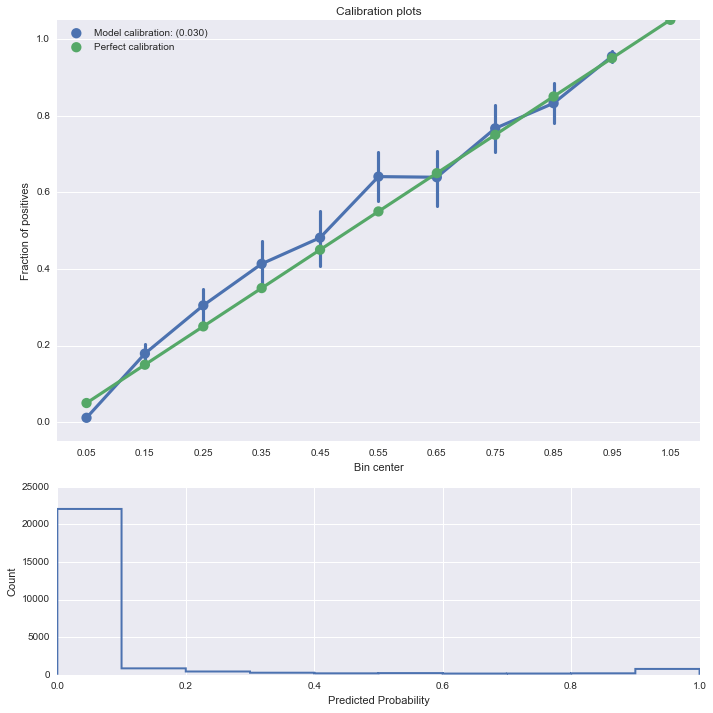

time: 45.9 s


In [32]:
y_test_oh = one_hot(y_test)
y_pred_ed = model.predict_proba(X_test)

if n_classes > 2:
    classes = range(n_classes)
else:
    classes = [1]

for i in classes:
    plt.figure()
    calibration_curve_plotter(y_test_oh[:, i], y_pred_ed[:, i])
    plt.show()

### Error Analysis

In [33]:
for i in classes:
    print('\n\n\nCLASS: ', i)
    over, under = get_errors(X_test, y_test_oh[:, i], y_pred_ed[:, i])
    print('\n\nOVER\n')
    print_errors(over, n=10)
    print('\n\nUNDER\n')
    print_errors(under, n=10)




CLASS:  1


OVER

COMMENT:
 Suck a dick you little cunt then go and take your uncle deep up your tight little ass
SCORES: Actual: 0.00, Predicted: 1.00, Residual: -1.00


COMMENT:
You Utter TwatWhat kind of stupid cunt reports someone for a perfectly valid username. You complete waste of oxygen, you rancid piece of dog shit. Get a sense of perspective and stop being a petty minded little fucker.
SCORES: Actual: 0.00, Predicted: 1.00, Residual: -1.00


COMMENT:
 hi if you know clown will kill me guy then tell him that he is stupid, ugly, fat, gay, his mother's a whore, he smells like shit, he's an asshole, a bastard, and his little name just might be the gayest fucking thing i have ever heard. Hey and you are a faggot as well, so don't ever send me a message while i am editing pages again or i will rape your mother and kill you.
SCORES: Actual: 0.00, Predicted: 1.00, Residual: -1.00


COMMENT:
MessageHey Dx927 you're a fat ugly cunt with the mental capacity of a 3-year-old amoeba. Wh

### Learning Curves!
How does adding more training data improve performance?

In [34]:
#ms, metrics = eval_adding_other_data(optimal_pipeline, None, None, X_test, y_test, X_train, y_train, roc_scorer)
#plot_adding_other_data(ms, metrics)

time: 760 µs


### Model Understanding

In [35]:
feature_names = np.array(model.named_steps['vect'].get_feature_names())
for i in classes:
    print('\n\nCLASS: ', i)
    
    try:
        coef = model.named_steps['clf'].coef_[i].ravel()
    except:
        coef = model.named_steps['clf'].coef_.ravel()
    most_pos_idx = np.argsort(coef)[-100:]
    most_pos = feature_names[most_pos_idx]
    print('STRONG POS: ')
    print(most_pos)
    most_neg_idx = np.argsort(coef)[:100]
    most_neg = feature_names[most_neg_idx]
    print('STRONG NEG: ')
    print(most_neg)



CLASS:  1
STRONG POS: 
['off' 'e a ' ' ter' 'tar' 'ora' 't ad' 'suck' 'bitch' ' pen' 't is a'
 'azi' ' fuc' 'u.' 'ou ' 'your' 'e pu' ' bitch' ' die ' 'aaaaaa' 'suck '
 'stop ' 'hell' ' na' '. f' 'cis' ' you' 'ss ' 'go ' ' hell' 'bitc' 'a d'
 'rd' 'uc' 'nke' 'e an ' ' bitc' ' yo' ' kil' 'bul' 'ose' ' cun' '! i'
 'sho' 'up' 'bas' 'ss' 'id' ' ' ' cunt' 'ck o' 'r b' 't u' 'utt' '!' 'uck'
 're an' 'et a' 'uck yo' 'ocks' ' off' 'umb' 'rap' 'fuck y' 'ur ' 'sex'
 'hu' ' u' 'sh' 'fag' ' y' 'uck y' 'dick' ' die' 'head' 'k of' 'ker'
 're a ' 'oron' '*' ' fag' 'ck' 'moro' 'hole' 'shit' 'ass' 'gay' 'fuck'
 'moron' ' u ' ' stu' ' ass' 'stu' 'pi' ' id' 'fuc' 'u ' 'yo' 'you' 'idi'
 'dio']
STRONG NEG: 
['uf' 'ssu' 'm a' 'sum' 'p i' 'they' ' ph' 'they ' '"' ' "' 'e go' 'gam'
 'hi ' '. ' 'x ' ' hi' ' but i' 'offe' 's a ' 'on' 'is ' 's d' 'fan' 'nic'
 'did' 'n your' '\nt' 'bt' 'r. ' 'le to' 's sh' 'is a' 'fun' 'but i' 'od'
 'hi' 'tho' 'j' 'did ' 'ook' 'ne i' 'g f' ' they ' ' on' 'nl' ' at ' ' pas'
 'if'

### Final Model

In [6]:
X, y = assemble_data(data, xtype, ytype)
final_model = optimal_pipeline.fit(X, y)
joblib.dump(final_model, '../../models/%s_ngram.pkl' % task)

['../../models/recipient_ngram.pkl',
 '../../models/recipient_ngram.pkl_01.npy',
 '../../models/recipient_ngram.pkl_02.npy',
 '../../models/recipient_ngram.pkl_03.npy',
 '../../models/recipient_ngram.pkl_04.npy',
 '../../models/recipient_ngram.pkl_05.npy',
 '../../models/recipient_ngram.pkl_06.npy']

time: 3min 19s
